# How to rediscover the Higgs boson yourself - with a Neural Network!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to apply Machine Learning in search for the Higgs boson!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

This notebook builds on [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb) in the same folder as this notebook. 

HZZAnalysis.ipynb loosely follows the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1)

Notebooks are a perfect platform to develop Machine Learning for your work, since you'll need exactly those 3 things: code, visualisations and narrative text!

We're interested in Machine Learning because we can design an algorithm to figure out for itself how to do various analyses, potentially saving us countless human-hours of design and analysis work.

Machine Learning use within ATLAS includes: 
* particle tracking
* particle identification
* signal/background classification 
* and more!

This notebook will focus on signal/background classification.

By the end of this notebook you will be able to:
1. run a Neural Network to classify signal and background
2. know some things you can change to improve your Neural Network

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/HZZ_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Optimisation](#optimisation) <br />
[Neural Network](#NN) <br />
  [Training and Testing split](#train_test) <br />
  [Data Preprocessing](#preprocessing) <br />
  [Training the Neural Network model](#training) <br />
  [Receiver Operating Characteristic (ROC) curve](#ROC) <br />
  [Overtraining check](#overtraining) <br />
  [Optimisation](#NN_optimisation) <br />
[Going further](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [3]:
# Install PyYAML if not already installed

import yaml
import subprocess
import sys

# Path to your binder/environment.yml file and this is a relative path 
environment_file = "../../binder/environment.yml"

# Packages you want to install
required_packages = ['scikit-learn', 'pandas', 'uproot3', 'numpy', 'matplotlib']

# Load the environment.yml file
with open(environment_file, 'r') as file:
    environment_data = yaml.safe_load(file)

# Extract dependencies
dependencies = environment_data.get('dependencies', [])

# Create a list to hold the packages with versions
install_packages = []

# Find the versions for the required packages
for dep in dependencies:
    # Check if the dependency is a string (package name)
    if isinstance(dep, str):
        for package in required_packages:
            if dep.startswith(package):
                install_packages.append(dep)

# Install packages using pip
if install_packages:
    print(f"Installing packages: {install_packages}")
    subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade"] + install_packages)
else:
    print("No matching packages found in environment.yml.")

Installing packages: ['matplotlib==3.9.1', 'numpy==1.26.4', 'pandas==2.2.2', 'scikit-learn==1.5.1', 'uproot3==3.14.4']



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in Machine Learning
* pandas: lets us store data as dataframes, a format widely used in Machine Learning
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [4]:
import uproot3 # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of fraction of data used, where to access the input files

### just for notes 
In the context of particle physics, **lumi** refers to **luminosity**, which is a measure of the number of particle collisions occurring in a particle accelerator, such as the Large Hadron Collider (LHC). 

#### Types of Luminosity:
1. **Instantaneous Luminosity**: 
   - Represents the collision rate per unit area at a given moment.
   - Measured in units of `cm⁻²s⁻¹`.

2. **Integrated Luminosity**:
   - Represents the total number of collisions over a period of time.
   - Measured in units of `inverse femtobarns (fb⁻¹)` or `inverse picobarns (pb⁻¹)`.

#### In Your Code:
In the notebook, `lumi` is defined as:
```python
lumi = 10  # fb-1 # data_A+B+C+D
```
This means the integrated luminosity is **10 inverse femtobarns (fb⁻¹)**, which corresponds to the total data collected from the A, B, C, and D datasets. It is used to calculate event weights and cross-sections for analysis.

In [5]:
lumi = 10 # fb-1 # data_A+B+C+D

#fraction = 0.03 # reduce this is you want the code to run quicker

#apr 26 change it to 0.1 to get the full dataset
fraction = 0.1 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

<a id='samples'></a>

## Samples

In this notebook we only process the signal <span style="color:blue">H->ZZ</span> and the main background <span style="color:red">ZZ</span>, for illustration purposes. You can add data and the Z and ttbar <span style="color:red">backgrounds</span> after if you wish.

In [6]:
samples = {

    'ZZ' : {
        'list' : ['llll']
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep'] # gluon-gluon fusion
    }

}

[Back to contents](#contents)

import the file locally

In [13]:
import uproot
import pandas as pd

# Define the paths to your local files
signal_file_path = "data/DAOD_PHYSLITE.37110937._000011.pool.root.1"
background_file_path = "data/DAOD_PHYSLITE.37110937._000011.pool.root.1"

# Open the signal and background files
signal_file = uproot.open(signal_file_path)
background_file = uproot.open(background_file_path)

# Access the trees (replace "mini" with the actual tree name in your files)
signal_tree = signal_file["CollectionTree"]
background_tree = background_file["CollectionTree"]

# Convert the trees to pandas DataFrames
signal_data = signal_tree.arrays(library="pd")
background_data = background_tree.arrays(library="pd")

# Print the first few rows to verify
print("Signal Data:")
print(signal_data.head())

print("\nBackground Data:")
print(background_data.head())

KeyboardInterrupt: 

Define function to get data from files. 

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [139]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

[Back to contents](#contents)

Define function to get cross-section weight

In [140]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

Define function to calculate weight of MC event

In [141]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

We add functions to return the individual lepton transverse momenta, in GeV

In [142]:
def calc_lep_pt_i(lep_pt,i):
    return lep_pt[i]/1000 # /1000 to go from MeV to GeV

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

We apply 'cuts' to throw away collisions that have properties different to the signal we're looking for.

If you change a cut: Cell -> Run All Below.

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [143]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [144]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini


#what is tree in here?
    #tree.show() # print the tree structure
    #tree.keys() # print the keys in the tree
    #tree.arrays() # print the arrays in the tree



    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_charge','lep_type','lep_pt',
                              # uncomment these variables if you want to calculate masses 
                              #,'lep_eta','lep_phi','lep_E', 
                              # add more variables here if you make cuts on them 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'
                             ], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)

        # return the individual lepton transverse momenta in GeV
        data['lep_pt_1'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,1)
        data['lep_pt_2'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,2)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = pd.concat([data_all, data], ignore_index=True) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts


[Back to contents](#contents)

apr 25: trying to find out what are the data set that they used in the sample

In [145]:
# Print the file paths used in the analysis
print("Environment file:", "../../binder/environment.yml")
print("Tuple path (ROOT files):", "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/")
print("ROOT files used:")
for sample, details in samples.items():
    for file in details['list']:
        print(f"  {sample}: {file}.4lep.root")

Environment file: ../../binder/environment.yml
Tuple path (ROOT files): https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/
ROOT files used:
  ZZ: llll.4lep.root
  $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$: ggH125_ZZ4lep.4lep.root


This is where the processing happens (this will take some minutes)

In [146]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing ZZ samples
	Processing: llll
		 nIn: 55427,	 nOut: 	52403	 in 211.5s
Processing $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ samples
	Processing: ggH125_ZZ4lep
		 nIn: 16471,	 nOut: 	16148	 in 457.8s
Time taken: 669.3s


[Back to contents](#contents)

<a id='optimisation'></a>

## Optimisation

Here we define histograms for the variables that we'll look to optimise

In [147]:
lep_pt_2 = { # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':13, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[2] [GeV]', # x-axis label
}

lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}

SoverB_hist_dict = {'lep_pt_2':lep_pt_2,'lep_pt_1':lep_pt_1} 
# add a histogram here if you want it plotted

[Back to contents](#contents)

Here we define a function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

In [148]:
def plot_SoverB(data):
    
    signal = r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries

    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.93, # y
                 'ATLAS Open Data', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.88, # y
                 'for education', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 style='italic',
                 fontsize=8 )  
    
        plt.show() # show the Signal and background distributions
    
    






    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return

[Back to contents](#contents)

Here we call our function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

We're not doing any Machine Learning yet! We're looking at the variables we'll later use for Machine Learning.

Let's talk through the lep_pt_2 plots.
1. Imagine placing a cut at 7 GeV in the distributions of <span style="color:blue">signal</span> and <span style="color:red">background</span> (1st plot). This means keeping all events above 7 GeV in the <span style="color:blue">signal</span> and <span style="color:red">background</span> histograms. 
2. We then take the ratio of the number of <span style="color:blue">signal</span> events that pass this cut, to the number of <span style="color:red">background</span> events that pass this cut. This gives us a starting value for S/B (2nd plot). 
3. We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more <span style="color:red">background</span> than <span style="color:blue">signal</span>, so S/B increases. 
4. There comes a point around 13 GeV where we start throwing away too much <span style="color:blue">signal</span>, thus S/B starts to decrease. 
5. Our goal is to find the maximum in S/B, and place the cut there.

The same logic applies to lep_pt_1.

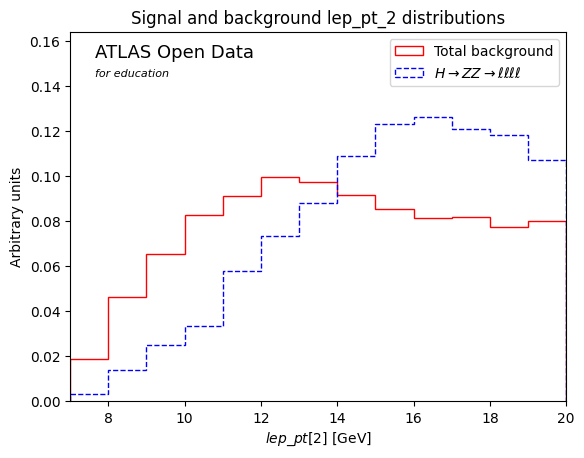

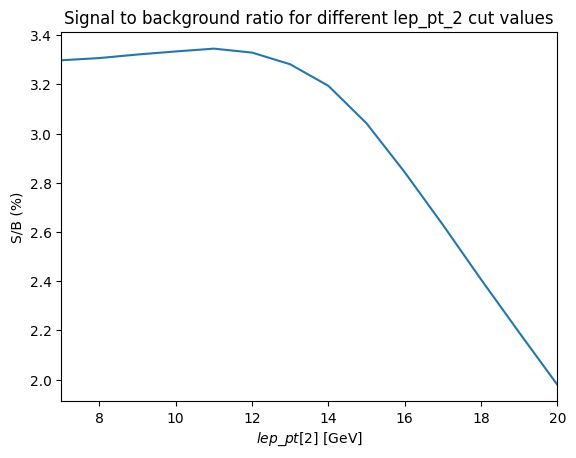

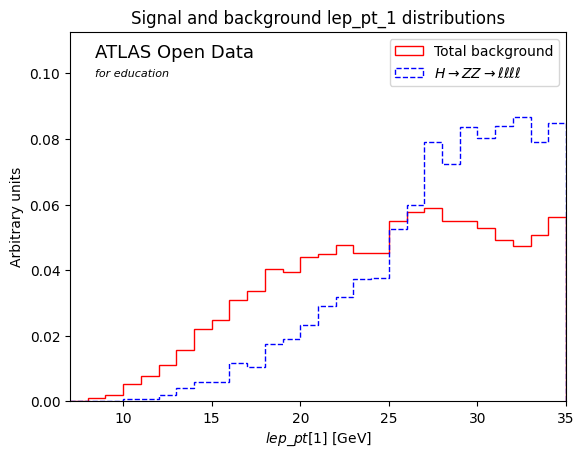

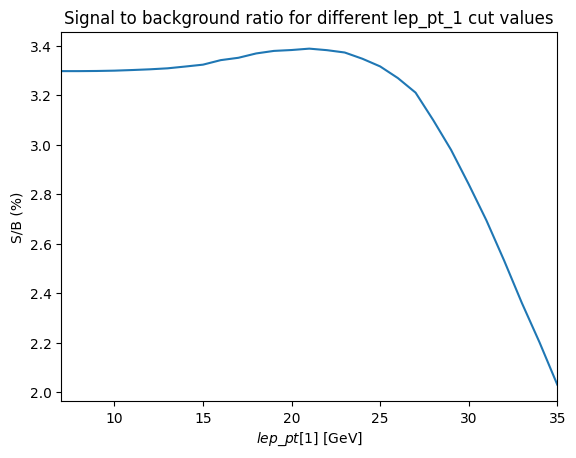

In [149]:
plot_SoverB(data)

[Back to contents](#contents)

In the [ATLAS Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X), there are a number of numerical cuts applied, not just on lep_pt_1 and lep_pt_2.

Imagine having to separately optimise about 7 variables! Not to mention that applying a cut on one variable could change the distribution of another, which would mean you'd have to re-optimise... Nightmare.

This is where a Machine Learning algorithm such as a Neural Network can come to the rescue. A Neural Network can optimise all variables at the same time.

A Neural Network not only optimises cuts, but can find correlations in many dimensions that will give better signal/background classification than individual cuts ever could.

That's the end of the introduction to why one might want to use a Neural Network. If you'd like to try using one, just keep reading below!

<a id='NN'></a>

## Neural Network

Choose variables for use in the Neural Network

In [150]:
data_for_NN = {} # define empty dictionary to hold dataframes that will be used to train the NN
NN_inputs = ['lep_pt_1','lep_pt_2'] # list of features for Neural Network
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_NN[key] = data[key][NN_inputs].copy()
data_for_NN

{'ZZ':         lep_pt_1   lep_pt_2
 0      61.677957  48.666441
 1      41.498750  18.562252
 2      78.250461  56.973090
 3      26.851668  13.466778
 4      98.566398  74.528453
 ...          ...        ...
 52398  86.575531  46.486250
 52399  42.137730  40.372977
 52400  92.480023  25.975883
 52401  64.939672  42.081762
 52402  42.284914  38.276031
 
 [52403 rows x 2 columns],
 '$H \\rightarrow ZZ \\rightarrow \\ell\\ell\\ell\\ell$':         lep_pt_1   lep_pt_2
 0      41.248570  16.397670
 1      40.307168  16.133789
 2      27.313271  20.035949
 3      27.845740  17.726541
 4      53.367754  25.596689
 ...          ...        ...
 16143  28.186676   9.106626
 16144  29.848680  22.983998
 16145  50.935629  15.567990
 16146  16.769477  13.660493
 16147  16.362849  11.859668
 
 [16148 rows x 2 columns]}

[Back to contents](#contents)

In [151]:
print("Features used in the Neural Network:", NN_inputs)

Features used in the Neural Network: ['lep_pt_1', 'lep_pt_2']


 Organise data ready for the NN

In [152]:
# for sklearn data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_NN[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!=r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_NN[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_NN[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

[Back to contents](#contents)

<a id='train_test'></a>

### The Training and Testing split
One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of <span style="color:orange">X</span> for training and the last 33% for testing. This is particularly important in cases where you load all <span style="color:blue">signal</span> events first and then the <span style="color:red">background</span> events.

Here we split our data into two independent samples. The split is to create a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

We don't want to test on events that we used to train on, this prevents overfitting to some subset of data so the network would be good for the test data but much worse at any *new* data it sees.

In [153]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=492 )

In [187]:

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


[Back to contents](#contents)

what is random_state and test_

<a id='preprocessing'></a>

### Data Preprocessing for Neural Network

The neural network in Python may have difficulty converging before the maximum number of iterations allowed if the data is not standardized. Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. Note that you must apply the same scaling to the test set for meaningful results. There are a lot of different methods for standardization of data, we will use the built-in StandardScaler this time.

#### 🧠 Why do we need feature scaling?
Imagine your data has two features:

lep_pt_1 (lepton momentum) ranging from 10 to 100 GeV

lep_pt_2 ranging from 5 to 50 GeV

If you don't scale:

The Neural Network will think lep_pt_1 is much more "important" than lep_pt_2, just because the numbers are bigger — even if that's not physically true.

✅ After scaling, both will range between similar numbers (like 0 to 1, or -1 to 1).
✅ This makes training faster, more stable, and more accurate.



In [188]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler

# Fit only to the training data
scaler.fit(X_train)

StandardScaler()

In [189]:
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

[Back to contents](#contents)

<a id='training'></a>

yayyyyyyyy

### Training the Neural Network model
Now it is time to train our model. We'll use SciKit Learn (sklearn) in this tutorial. Other possible tools include keras and pytorch. 

SciKit Learn makes training simpler, by using estimator objects. In this case we will import our estimator (the Multi-Layer Perceptron Classifier model) from the neural_network library of SciKit-Learn

**okay af*ter reading this the question i have are fowllowing:**
1. are there any other neural_network lirbary
2. are there any other estimator?

In [190]:
from sklearn.neural_network import MLPClassifier

**from daniel**
okay so what are some example of the parameters we can choose. 


and below they only define the hidden_layer size (passed in a tuple)



Next we create an instance of the model, there are a lot of parameters you can choose to define and customize here, we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of **neurons** you want at each layer, where the **nth** entry in the tuple represents the number of **neurons** in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose **1 layer** with the same number of neurons as there are features in our data set along with 200 max iterations.

In [191]:

# hidden_layer_sizes = [len(NN_inputs)] # 1 hidden layer
# mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), # define parameters for our multi-layer-perceptron
#                     max_iter=200 ) # max number of iterations


now i am trying to modity the layers of neurons and then the neurons per layers

In [192]:
# trail 1 and this is not reaching the s/b limit 

# Define the hidden layers and neurons per layer
hidden_layer_sizes = (10, 5, 3)  # Example: 3 layers with 10, 5, and 3 neurons respectively

# Create the MLPClassifier with the specified hidden layers
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,  # Define the layers and neurons
                    max_iter=200)  # Max number of iterations

In [193]:
# # trail 2 and this is not reaching the s/b limit

# hidden_layer_sizes = (20, 15, 10)  # 3 layers with 20, 15, and 10 neurons
# mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=300)

In [194]:
# # trail 3 with fraction = 0.1 and this is not reaching the s/b limit

# hidden_layer_sizes = (50, 30, 20)  # Deeper network
# mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
#                      activation='relu', 
#                      solver='adam', 
#                      alpha=0.0001, 
#                      learning_rate_init=0.001, 
#                      max_iter=1000)
# mlp.fit(X_train, y_train)

In [195]:
# # trail 4 with fraction = 0.1 and this is not reaching the s/b limit
# hidden_layer_sizes = (100, 50, 25)  # Deeper network
# mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
#                      activation='relu', 
#                      solver='adam', 
#                      alpha=0.0001, 
#                      learning_rate_init=0.001, 
#                      max_iter=2000)
# mlp.fit(X_train, y_train)

In [196]:
# apr 26th this actaully decreaed the s/b ratio and more layers does not help?


# Define a deeper network with more layers and neurons
hidden_layer_sizes = (256, 128, 64, 32, 16)  # Example: 5 layers with decreasing neurons

# Create the MLPClassifier with the specified hidden layers
mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,  # Define the layers and neurons
    activation='relu',                     # Activation function
    solver='adam',                         # Optimizer
    alpha=0.0001,                          # L2 regularization term
    learning_rate_init=0.001,              # Initial learning rate
    max_iter=2000,                         # Max number of iterations
    verbose=True                           # Print progress during training
)

# Train the model
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.40571546
Iteration 2, loss = 0.37406012
Iteration 3, loss = 0.37190160
Iteration 4, loss = 0.37141455
Iteration 5, loss = 0.37206881
Iteration 6, loss = 0.37101242
Iteration 7, loss = 0.37109927
Iteration 8, loss = 0.37052980
Iteration 9, loss = 0.37029519
Iteration 10, loss = 0.37037450
Iteration 11, loss = 0.37023153
Iteration 12, loss = 0.37032752
Iteration 13, loss = 0.37020063
Iteration 14, loss = 0.37077842
Iteration 15, loss = 0.37004031
Iteration 16, loss = 0.36943779
Iteration 17, loss = 0.37013372
Iteration 18, loss = 0.36954178
Iteration 19, loss = 0.36959334
Iteration 20, loss = 0.37008399
Iteration 21, loss = 0.36967157
Iteration 22, loss = 0.36987225
Iteration 23, loss = 0.37005788
Iteration 24, loss = 0.36942480
Iteration 25, loss = 0.36996715
Iteration 26, loss = 0.36967423
Iteration 27, loss = 0.37015975
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32, 16), max_iter=2000,
              verbose=True)

apr25 i added a new layer of neurons and the result seems to be promising the signal to noise radio increased a lot in the first few output but i don't know why

In [197]:
# hidden_layer_sizes = [len(NN_inputs), len(NN_inputs), len(NN_inputs)]  # Two hidden layers with the same number of neurons as features
# mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,  # Define parameters for our multi-layer-perceptron
#                     max_iter=200)  # Max number of iterations

Now that the model has been made we can fit the training data to our model, remember that this data has already been processed and scaled:

In [198]:
#print(X_train)
mlp.fit(X_train,y_train)

Iteration 1, loss = 0.39957273
Iteration 2, loss = 0.37403228
Iteration 3, loss = 0.37283981
Iteration 4, loss = 0.37161480
Iteration 5, loss = 0.37246648
Iteration 6, loss = 0.37219802
Iteration 7, loss = 0.37101369
Iteration 8, loss = 0.37173699
Iteration 9, loss = 0.37091530
Iteration 10, loss = 0.37076283
Iteration 11, loss = 0.37082187
Iteration 12, loss = 0.37130687
Iteration 13, loss = 0.36960334
Iteration 14, loss = 0.37035165
Iteration 15, loss = 0.36996131
Iteration 16, loss = 0.37093584
Iteration 17, loss = 0.37011041
Iteration 18, loss = 0.36991837
Iteration 19, loss = 0.37021466
Iteration 20, loss = 0.36969549
Iteration 21, loss = 0.36920516
Iteration 22, loss = 0.37014155
Iteration 23, loss = 0.36970478
Iteration 24, loss = 0.36963775
Iteration 25, loss = 0.37026937
Iteration 26, loss = 0.36922708
Iteration 27, loss = 0.36969322
Iteration 28, loss = 0.36942856
Iteration 29, loss = 0.36958667
Iteration 30, loss = 0.36935382
Iteration 31, loss = 0.36990124
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32, 16), max_iter=2000,
              verbose=True)

You can see the output that shows the default values of the other parameters in the model. We encourage you to play around with them and discover what effects they have on your neural network in Python.

[Back to contents](#contents)

<a id='ROC'></a>

### Receiver Operarting Characteristic (ROC) curve for Neural Network
Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

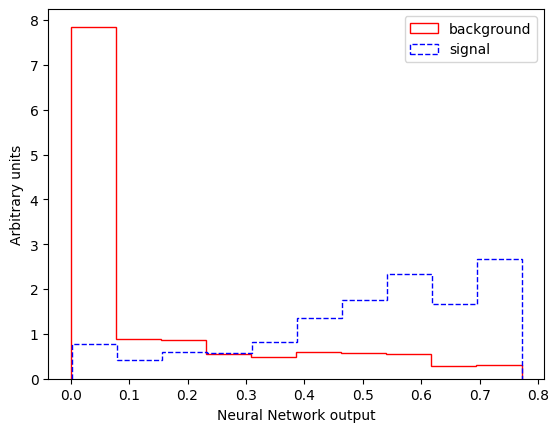

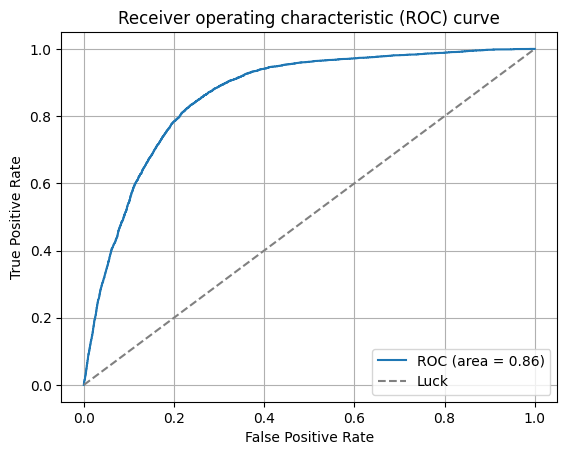

In [199]:
# we first plot the Neural Network output
signal_decisions = mlp.predict_proba(X[y>0.5])[:, 1] # get probabilities on signal
background_decisions = mlp.predict_proba(X[y<0.5])[:, 1] # get probabilities on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('Neural Network output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

decisions = mlp.predict_proba(X_test)[:, 1] # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid

Sliding the cut threshold in Neural Network output (upper plot) from right to left builds up the ROC curve (lower plot) from bottom to top.

[Back to contents](#contents)

<a id='overtraining'></a>

### Neural Network Overtraining Check
Comparing the Neural Network's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The <span style="color:orange">compare_train_test()</span> method will plot the shape of the Neural Network's decision function for each class, as well as overlaying it with the decision function in the training set.

There are techniques to prevent overtraining.

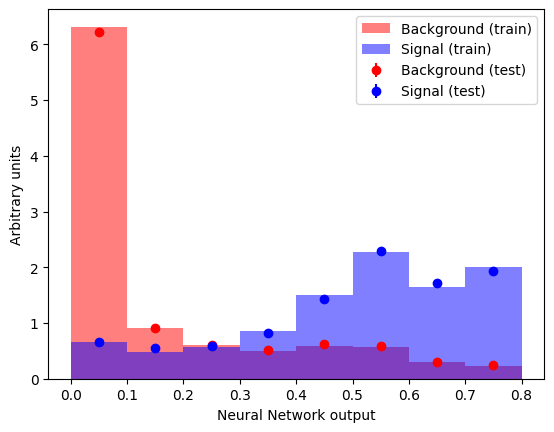

In [200]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
        d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel("Neural Network output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    
compare_train_test(mlp, X_train, y_train, X_test, y_test) # call compare_train_test

[Back to contents](#contents)

<a id='NN_optimisation'></a>

### Neural Network Optimisation

Here we get the Neural Network's prediction probability for every event that was processed at the begininning (so could be data, <span style="color:blue">signal</span>, <span style="color:red">background</span>...). The higher the probability, the more the Neural Network thinks that event looks like <span style="color:blue">signal</span>.

In [201]:
y_predicted = mlp.predict_proba(X)[:, 1]
y_predicted

array([0.02084651, 0.74745361, 0.01892808, ..., 0.42356317, 0.21467311,
       0.16926781])

In this cell we save the Neural Network output to our dataframes.

In [202]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    data[key]['NN_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
    cumulative_events += len(data[key]) # increment counter for total number of events
    print(data[key]['NN_output']) # print the dataframe column NN_output

0        0.020847
1        0.747454
2        0.018928
3        0.386210
4        0.012086
           ...   
52398    0.019822
52399    0.032376
52400    0.015196
52401    0.020974
52402    0.042506
Name: NN_output, Length: 52403, dtype: float64
0        0.769986
1        0.771341
2        0.533825
3        0.548847
4        0.102120
           ...   
16143    0.209098
16144    0.601777
16145    0.423563
16146    0.214673
16147    0.169268
Name: NN_output, Length: 16148, dtype: float64


[Back to contents](#contents)

Here we define parameters to plot the Neural Network output

In [203]:
NN_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':7, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network output', # x-axis label
}

SoverB_hist_dict = {'NN_output':NN_output}

Here we call the function defined above to to illustrate the optimum cut value on Neural Network output, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

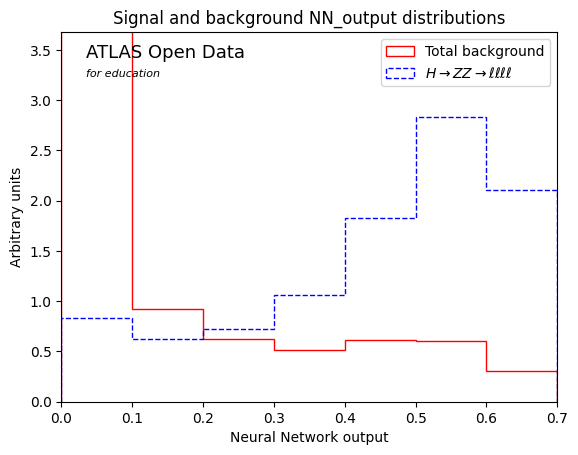

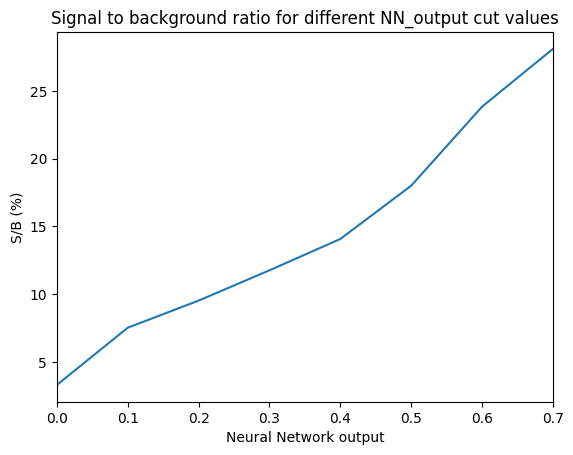

In [204]:
plot_SoverB(data)

[Back to contents](#contents)

Putting everything into a Neural Network means we only have 1 variable to optimise. The <span style="color:blue">signal</span> and <span style="color:red">background</span> distributions are separated much better when looking at Neural Network output, compared to individual variables. Cutting on Neural Network output also achieves much higher S/B values than on individual variables.

Neural Networks can achieve better S/B ratios because they find correlations in many dimensions that will give better signal/background classification.

Hopefully you've enjoyed this discussion on optimising for <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio, and in particular how a Neural Network can be used to facilitate this.

<a id='going_further'></a>

## Going further

If you want to go further, there are a number of things you could try: 
* Increase the fraction of events that are processed in '[Lumi, fraction, file path](#fraction)'.
* Add in the other <span style="color:blue">H->ZZ signal</span> samples in '[Samples](#samples)'. You can copy them from [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Try adding them one at a time first, then see how things look with all added.
* Add in the Z and ttbar <span style="color:red">backgrounds</span> samples in '[Samples](#samples)'. You can copy them from [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Try adding them separately first, then see how things look with both added.
* Add some more variables into the Neural Network in '[Neural Network](#NN)'. Add them in one at a time, rather than all at once, because adding a variable could decrease Neural Network performance, due to anti-correlation. For some ideas of variables, you can look at the paper for the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1).
* Add in real data in '[Samples](#samples)' and see whether the Neural Network output distributions in data and simulation match. You can copy data from [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). 
* Modify some Neural Network hyper-parameters in '[Training the Neural Network model](#training)'.

With each change, keep an eye on the:
* total area under the ROC curve, 
* separation between <span style="color:blue">signal</span> and <span style="color:red">background</span> in the Neural Network output distribution
* S/B scores that can be achieved

Notice that we've trained and tested our Neural Network on simulated data. We would then *apply* it to real experimental data. Once you're happy with your Neural Network, you may want to put it back into a full analysis to run over all data.

[Back to contents](#contents)